In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from skbio import DistanceMatrix

plt.style.use("./paper.mplstyle")

In [2]:
df_orig = pd.read_table("../data/ref/ag_map_with_alpha.txt.quartiles.tsv", sep="\t", index_col=0)
df_orig.index = "S" + df_orig.index
print(df_orig.shape)
df_orig.head()

(9511, 146)


,center_project_name,extraction_robot,plating,primer_plate,processing_robot,acid_reflux,acne_medication_otc,add_adhd,age_cat,alcohol_consumption,...,vioscreen_erythr,vioscreen_fiber,vioscreen_fol_deqv,vioscreen_formontn,vioscreen_grams,vioscreen_inositol,vioscreen_lutzeax,vioscreen_lycopene,vioscreen_tfa181t,vioscreen_xylitol
#SampleID,,,,,,,,,,,,,,,,,,,,,
S10317.000028848,AG19,NaN,NaN,NaN,NaN,NaN,Yes,"Diagnosed by a medical professional (doctor, p...",30s,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S10317.000049761,NaN,NaN,NaN,5.0,ROBE,I do not have this condition,No,I do not have this condition,50s,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S10317.000059054,NaN,HOWE_KF1,LDG,7.0,CARMEN,I do not have this condition,No,I do not have this condition,60s,Yes,...,2.0,2.0,3.0,2.0,2.0,3.0,2.0,1.0,1.0,2.0
S10317.000030512,AG25,HOWE_KF2,LDG,6.0,JERE,NaN,No,I do not have this condition,30s,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S10317.000040165,NaN,HOWE_KF1,LDG,5.0,ROBE,NaN,No,I do not have this condition,30s,Yes,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0


In [3]:
## Remap since some failed

cond_map = {
    "I do not have this condition": "No",
    "Diagnosed by a medical professional (doctor, physician assistant)": "Yes",
    "Self-diagnosed": np.nan,
    "Diagnosed by an alternative medicine practitioner": np.nan,
}

def replace_cond(item_1):
    if item_1 in cond_map:
        return cond_map[item_1]
    else:
        return item_1
    
q_map = {0.0: "q1", 1.0: "q2", 2.0: "q3", 3.0: "q4"}
    
for col in df_orig:
    df_orig[col] = df_orig[col].map(replace_cond)
    if set(df_orig[col].dropna().unique()) == {0.0, 1.0, 2.0, 3.0}:
        df_orig[col] = df_orig[col].map(q_map)

print(df_orig.shape)

(9511, 146)


In [4]:
agp_results = pd.read_excel(
    "../data/ref/sys003182229st2.xlsx",
    sheet_name="Effect size, unweighted UniFrac",
    header=0
)
agp_results[["group_1", "group_2"]] = agp_results["effect_size_values"].str.split(" vs. ", expand=True)
q_map = {"0.0": "q1", "1.0": "q2", "2.0": "q3", "3.0": "q4"}
agp_results["group_1"] = agp_results["group_1"].replace(q_map)
agp_results["group_2"] = agp_results["group_2"].replace(q_map)

agp_results["group_1"] = agp_results["group_1"].map(replace_cond)
agp_results["group_2"] = agp_results["group_2"].map(replace_cond)

agp_results = agp_results.replace({"Child": "child"})

print(agp_results.shape)
agp_results.head()

(113, 8)


,column_name,effect_size,effect_size_square,effect_size_values,pval_corrected,pval,group_1,group_2
0,age_cat,0.616142,0.379631,Child vs. 60s,0.000323,0.0002,child,60s
1,center_project_name,0.497663,0.247668,AG1 vs. AG23,0.000323,0.0002,AG1,AG23
2,antibiotic_history,0.388949,0.151281,Month vs. I have not taken antibiotics in the ...,0.000323,0.0002,Month,I have not taken antibiotics in the past year.
3,processing_robot,0.387074,0.149826,RikE vs. LUCY,0.000323,0.0002,RikE,LUCY
4,prepared_meals_frequency,0.375348,0.140886,Occasionally (1-2 times/week) vs. Never,0.000323,0.0002,Occasionally (1-2 times/week),Never


In [5]:
na_vals = ["Not provided"]
df_new = pd.read_table("../data/processed/metadata.disambig.filt.tsv", sep="\t", index_col=0,
                       na_values=na_vals)
print(df_new.shape)
df_new.head()

(9511, 94)


,homecooked_meals_frequency,lactose,bowel_movement_quality,last_move,non_food_allergies_sun,drinking_water_source,consume_animal_products_abx,pool_frequency,weight_change,lung_disease,...,multivitamin,mental_illness,skin_condition,tonsils_removed,chickenpox,cancer,country,sugary_sweets_frequency,mental_illness_type_ptsd_posttraumatic_stress_disorder,cardiovascular_disease
#SampleID,,,,,,,,,,,,,,,,,,,,,
S10317.000033192.128811,Regularly (3-5 times/week),No,I tend to be constipated (have difficulty pass...,I have lived in my current state of residence ...,No,Bottled,No,Rarely (a few times/month),Remained stable,No,...,No,NaN,No,NaN,Yes,NaN,United Kingdom,Regularly (3-5 times/week),NaN,No
S10317.000036180.129405,Regularly (3-5 times/week),No,I tend to have normal formed stool,I have lived in my current state of residence ...,No,City,Yes,Rarely (a few times/month),Remained stable,No,...,Yes,NaN,Yes,No,Yes,NaN,USA,Occasionally (1-2 times/week),NaN,No
S10317.000015865.129965,NaN,No,NaN,NaN,No,City,NaN,Rarely (a few times/month),Increased more than 10 pounds,No,...,No,NaN,NaN,No,Yes,NaN,USA,NaN,NaN,NaN
S10317.000052028.129789,Regularly (3-5 times/week),Yes,I tend to have normal formed stool,I have lived in my current state of residence ...,No,City,Yes,Never,Remained stable,No,...,No,No,No,Yes,No,No,USA,Rarely (less than once/week),No,No
S10317.000058947.129642,Daily,No,I tend to have diarrhea (watery stool),I have lived in my current state of residence ...,No,City,Yes,Rarely (a few times/month),Remained stable,No,...,Yes,No,No,No,Yes,No,United Kingdom,Rarely (less than once/week),No,No


In [6]:
set(agp_results["column_name"]).difference(df_new.columns)

{'age_cat',
 'alcohol_consumption',
 'alcohol_types_beercider',
 'alcohol_types_red_wine',
 'alcohol_types_spiritshard_alcohol',
 'alcohol_types_white_wine',
 'allergic_to_i_have_no_food_allergies_that_i_know_of',
 'bmi_corrected',
 'elevation',
 'height_cm',
 'latitude',
 'longitude',
 'roommates',
 'vioscreen_a_bev',
 'vioscreen_add_sug',
 'vioscreen_alphacar',
 'vioscreen_alphtoce',
 'vioscreen_avcarb',
 'vioscreen_betacryp',
 'vioscreen_biochana',
 'vioscreen_caffeine',
 'vioscreen_calcium',
 'vioscreen_copper',
 'vioscreen_d_cheese',
 'vioscreen_erythr',
 'vioscreen_f_citmlb',
 'vioscreen_fiber',
 'vioscreen_fol_deqv',
 'vioscreen_formontn',
 'vioscreen_g_whl',
 'vioscreen_grams',
 'vioscreen_inositol',
 'vioscreen_lutzeax',
 'vioscreen_lycopene',
 'vioscreen_m_fish_hi',
 'vioscreen_m_frank',
 'vioscreen_m_meat',
 'vioscreen_m_mpf',
 'vioscreen_salad_vegetable_servings',
 'vioscreen_tfa181t',
 'vioscreen_xylitol',
 'weight_corrected'}

In [7]:
set(df_new.columns).difference(agp_results["column_name"])

{'allergic_to_shellfish',
 'artificial_sweeteners',
 'cancer',
 'cardiovascular_disease',
 'dominant_hand',
 'lung_disease',
 'mental_illness',
 'mental_illness_type_ptsd_posttraumatic_stress_disorder',
 'migraine',
 'non_food_allergies_beestings',
 'non_food_allergies_drug_eg_penicillin',
 'non_food_allergies_pet_dander',
 'non_food_allergies_poison_ivyoak',
 'non_food_allergies_sun',
 'pets_other',
 'skin_condition',
 'smoking_frequency',
 'specialized_diet_exclude_refined_sugars',
 'specialized_diet_modified_paleo_diet',
 'specialized_diet_other_restrictions_not_described_here',
 'specialized_diet_westenprice_or_other_lowgrain_low_processed_fo',
 'state',
 'vivid_dreams'}

In [8]:
common_cols = set(df_new.columns).intersection(agp_results["column_name"])

In [9]:
pw_new = pd.read_table("../results/beta_pairwise_effect_size_by_cat.tsv",
                       sep="\t", index_col=0).dropna()

pw_new["group_1"] = pw_new["group_1"].replace({"Child": "child"})
pw_new["group_2"] = pw_new["group_2"].replace({"Child": "child"})

_dfs = []
for i, row in agp_results.iterrows():
    g1, g2 = row[["group_1", "group_2"]]
    x = pw_new[
        (((pw_new["group_1"] == g1) & (pw_new["group_2"] == g2))
        | ((pw_new["group_1"] == g2) & (pw_new["group_2"] == g1)))
        & (pw_new["column"] == row["column_name"])
    ]
    _dfs.append(x)
    
evident_df_new = pd.concat(_dfs).reset_index(drop=True)
print(evident_df_new.shape)
evident_df_new.head()

(70, 5)


,effect_size,metric,column,group_1,group_2
0,0.103310,cohens_d,center_project_name,AG1,AG23
1,0.417409,cohens_d,antibiotic_history,I have not taken antibiotics in the past year.,Month
2,0.407101,cohens_d,processing_robot,LUCY,RikE
3,0.350438,cohens_d,prepared_meals_frequency,Never,Occasionally (1-2 times/week)
4,0.307478,cohens_d,race,Asian or Pacific Islander,Caucasian


In [10]:
comp_df_agp_new = (
    agp_results.set_index("column_name")
    .join(evident_df_new.set_index("column"), lsuffix="_agp", rsuffix="_evident", how="inner")
)
comp_df_agp_new = comp_df_agp_new.drop(index=["center_project_name"])
comp_df_agp_new["es_diff"] = comp_df_agp_new["effect_size_agp"] - comp_df_agp_new["effect_size_evident"]
comp_df_agp_new["es_diff_abs"] = np.abs(comp_df_agp_new["es_diff"])
comp_df_agp_new = comp_df_agp_new.sort_values(by="effect_size_evident", ascending=False)
print(comp_df_agp_new.shape)
comp_df_agp_new.head(10)

(69, 13)


,effect_size_agp,effect_size_square,effect_size_values,pval_corrected,pval,group_1_agp,group_2_agp,effect_size_evident,metric,group_1_evident,group_2_evident,es_diff,es_diff_abs
antibiotic_history,0.388949,0.151281,Month vs. I have not taken antibiotics in the ...,0.000323,0.0002,Month,I have not taken antibiotics in the past year.,0.417409,cohens_d,I have not taken antibiotics in the past year.,Month,-0.028460,0.028460
processing_robot,0.387074,0.149826,RikE vs. LUCY,0.000323,0.0002,RikE,LUCY,0.407101,cohens_d,LUCY,RikE,-0.020027,0.020027
prepared_meals_frequency,0.375348,0.140886,Occasionally (1-2 times/week) vs. Never,0.000323,0.0002,Occasionally (1-2 times/week),Never,0.350438,cohens_d,Never,Occasionally (1-2 times/week),0.024911,0.024911
country,0.319858,0.102309,United Kingdom vs. USA,0.000323,0.0002,United Kingdom,USA,0.340109,cohens_d,USA,United Kingdom,-0.020251,0.020251
salted_snacks_frequency,0.345779,0.119563,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.321925,cohens_d,Never,Regularly (3-5 times/week),0.023853,0.023853
collection_month,0.300554,0.090333,February vs. June,0.000323,0.0002,February,June,0.321882,cohens_d,February,June,-0.021328,0.021328
sugary_sweets_frequency,0.335986,0.112887,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.313500,cohens_d,Never,Regularly (3-5 times/week),0.022486,0.022486
race,0.366027,0.133976,Caucasian vs. Asian or Pacific Islander,0.000323,0.0002,Caucasian,Asian or Pacific Islander,0.307478,cohens_d,Asian or Pacific Islander,Caucasian,0.058549,0.058549
fruit_frequency,0.305122,0.093100,Occasionally (1-2 times/week) vs. Never,0.000323,0.0002,Occasionally (1-2 times/week),Never,0.296163,cohens_d,Never,Occasionally (1-2 times/week),0.008959,0.008959
types_of_plants,0.298036,0.088826,Less than 5 vs. More than 30,0.000323,0.0002,Less than 5,More than 30,0.279151,cohens_d,Less than 5,More than 30,0.018886,0.018886


In [11]:
comp_df_agp_new.sort_values(by="es_diff", ascending=False).head(10)

,effect_size_agp,effect_size_square,effect_size_values,pval_corrected,pval,group_1_agp,group_2_agp,effect_size_evident,metric,group_1_evident,group_2_evident,es_diff,es_diff_abs
contraceptive,0.125246,0.015687,"No vs. Yes, I am taking the ""pill""",0.000323,0.0002,No,"Yes, I am taking the ""pill""",0.054820,cohens_d,No,"Yes, I am taking the ""pill""",0.070426,0.070426
homecooked_meals_frequency,0.100685,0.010137,Daily vs. Occasionally (1-2 times/week),0.000323,0.0002,Daily,Occasionally (1-2 times/week),0.039280,cohens_d,Daily,Occasionally (1-2 times/week),0.061404,0.061404
race,0.366027,0.133976,Caucasian vs. Asian or Pacific Islander,0.000323,0.0002,Caucasian,Asian or Pacific Islander,0.307478,cohens_d,Asian or Pacific Islander,Caucasian,0.058549,0.058549
fermented_plant_frequency,0.145931,0.021296,Rarely (less than once/week) vs. Daily,0.000323,0.0002,Rarely (less than once/week),Daily,0.094217,cohens_d,Daily,Rarely (less than once/week),0.051715,0.051715
ready_to_eat_meals_frequency,0.183763,0.033769,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.139214,cohens_d,Never,Regularly (3-5 times/week),0.044549,0.044549
chickenpox,0.056315,0.003171,No vs. Yes,0.000323,0.0002,No,Yes,0.015546,cohens_d,No,Yes,0.040769,0.040769
acne_medication_otc,0.071467,0.005108,No vs. Yes,0.000323,0.0002,No,Yes,0.033537,cohens_d,No,Yes,0.037931,0.037931
milk_substitute_frequency,0.129965,0.016891,Rarely (less than once/week) vs. Daily,0.000323,0.0002,Rarely (less than once/week),Daily,0.093202,cohens_d,Daily,Rarely (less than once/week),0.036762,0.036762
add_adhd,0.034334,0.001179,"Diagnosed by a medical professional (doctor, p...",0.000323,0.0002,Yes,No,0.006817,cohens_d,No,Yes,0.027517,0.027517
gluten,0.093959,0.008828,I do not eat gluten because it makes me feel b...,0.000323,0.0002,I do not eat gluten because it makes me feel bad,No,0.067595,cohens_d,I do not eat gluten because it makes me feel bad,No,0.026364,0.026364


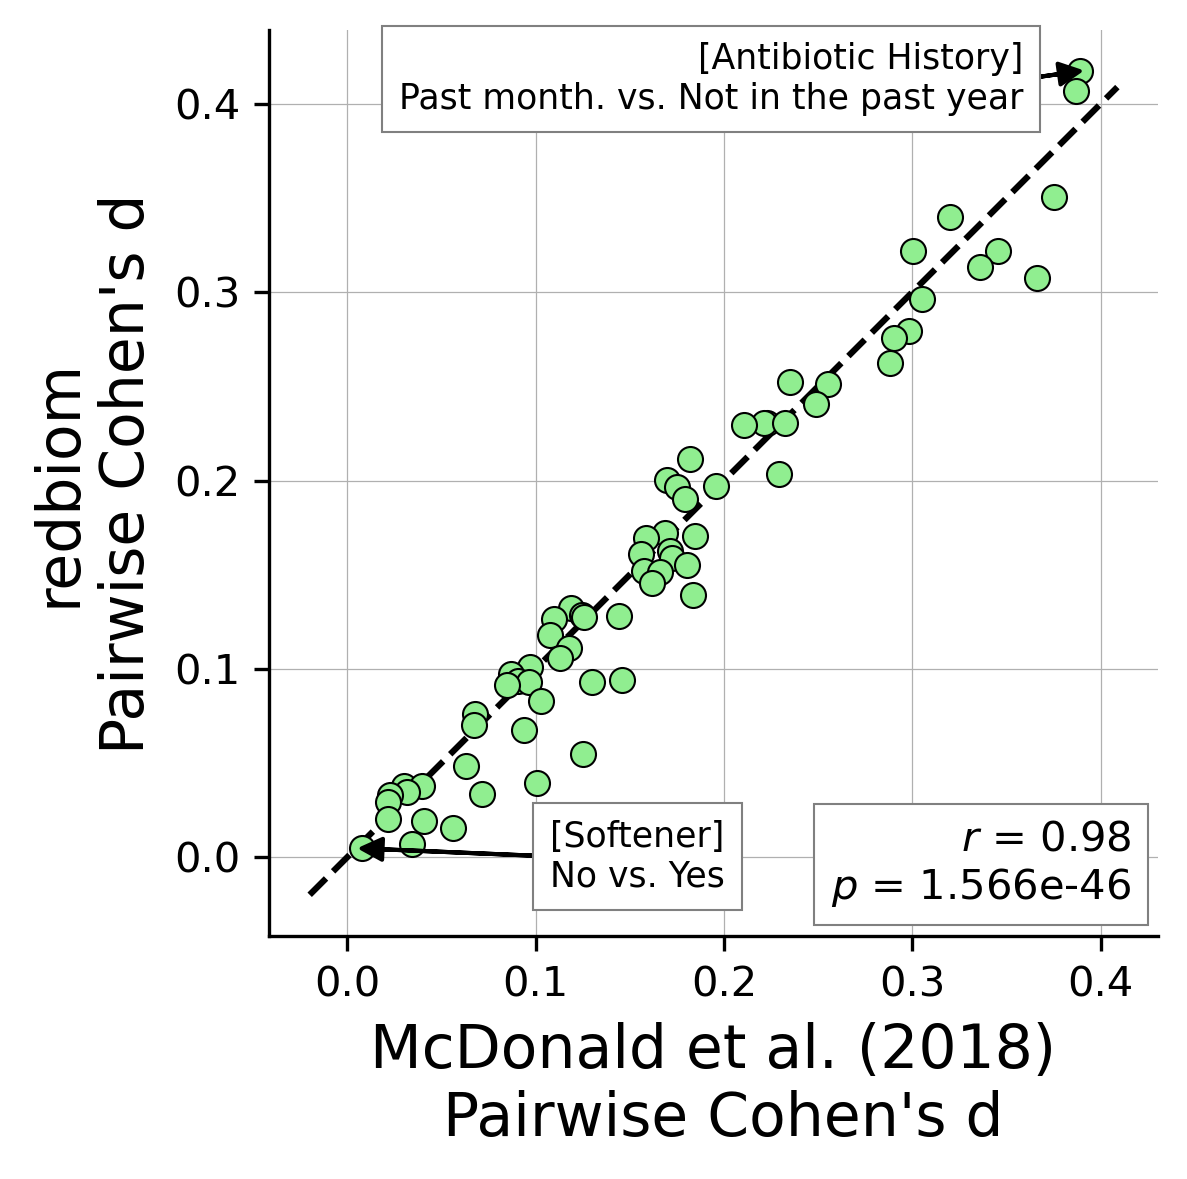

In [12]:
fig, ax = plt.subplots(1, 1)
ax.set_aspect("equal")

sns.scatterplot(
    data=comp_df_agp_new,
    x="effect_size_agp",
    y="effect_size_evident",
    linewidth=0.5,
    color="lightgreen",
    edgecolor="black",
    zorder=2,
    ax=ax
)

max_val = min(comp_df_agp_new["effect_size_agp"].max(), comp_df_agp_new["effect_size_evident"].max())
ax.plot(
    [0-0.02, max_val+0.02], [0-0.02, max_val+0.02],
    color="black",
    ls="--",
    zorder=1
)

ax.set_xlabel("McDonald et al. (2018)\n Pairwise Cohen's d")
ax.set_ylabel("redbiom\n Pairwise Cohen's d")

bbox = {"facecolor": "white", "alpha": 1, "lw": 0.5, "edgecolor": "gray"}
r, pval = ss.pearsonr(comp_df_agp_new["effect_size_agp"], comp_df_agp_new["effect_size_evident"])
ax.text(
    x=0.97,
    y=0.03,
    s=f"$r$ = {r:.2f}\n$p$ = {pval:.3e}",
    transform=ax.transAxes,
    ha="right",
    va="bottom",
    bbox=bbox
)

arrowprops = {"facecolor": "black", "width": 0.005, "headwidth": 5, "headlength": 5}
top_cat = comp_df_agp_new.iloc[0]
bot_cat = comp_df_agp_new.iloc[-1]

abx_map = {"I have not taken antibiotics in the past year.": "Not in the past year",
           "Month": "Past month."}

top_cat_name = top_cat.name.replace("_", " ").title()
top_grp1 = abx_map[top_cat.group_1_agp]
top_grp2 = abx_map[top_cat.group_2_agp]
top_text = f"[{top_cat_name}]\n{top_grp1} vs. {top_grp2}"

bot_cat_name = bot_cat.name.replace("_", " ").title()
bot_grp1 = bot_cat.group_1_agp
bot_grp2 = bot_cat.group_2_agp
bot_text = f"[{bot_cat_name}]\n{bot_grp1} vs. {bot_grp2}"

ax.annotate(
    xy=(top_cat["effect_size_agp"], top_cat["effect_size_evident"]),
    xytext=(top_cat["effect_size_agp"] - 0.03, top_cat["effect_size_evident"] - 0.02),
    text=top_text,
    fontsize="small",
    ha="right",
    arrowprops=arrowprops,
    bbox=bbox
)
ax.annotate(
    xy=(bot_cat["effect_size_agp"], bot_cat["effect_size_evident"]),
    xytext=(bot_cat["effect_size_agp"] + 0.10, bot_cat["effect_size_evident"] - 0.02),
    text=bot_text,
    fontsize="small",
    ha="left",
    arrowprops=arrowprops,
    bbox=bbox
)

ax.grid(lw=0.3)
ax.set_axisbelow(True)

plt.savefig("../figures/redbiom_vs_published.pdf")
plt.show()

In [13]:
comp_df_agp_new.sort_values(by="es_diff_abs", ascending=False)

,effect_size_agp,effect_size_square,effect_size_values,pval_corrected,pval,group_1_agp,group_2_agp,effect_size_evident,metric,group_1_evident,group_2_evident,es_diff,es_diff_abs
contraceptive,0.125246,0.015687,"No vs. Yes, I am taking the ""pill""",0.000323,0.0002,No,"Yes, I am taking the ""pill""",0.054820,cohens_d,No,"Yes, I am taking the ""pill""",0.070426,0.070426
homecooked_meals_frequency,0.100685,0.010137,Daily vs. Occasionally (1-2 times/week),0.000323,0.0002,Daily,Occasionally (1-2 times/week),0.039280,cohens_d,Daily,Occasionally (1-2 times/week),0.061404,0.061404
race,0.366027,0.133976,Caucasian vs. Asian or Pacific Islander,0.000323,0.0002,Caucasian,Asian or Pacific Islander,0.307478,cohens_d,Asian or Pacific Islander,Caucasian,0.058549,0.058549
fermented_plant_frequency,0.145931,0.021296,Rarely (less than once/week) vs. Daily,0.000323,0.0002,Rarely (less than once/week),Daily,0.094217,cohens_d,Daily,Rarely (less than once/week),0.051715,0.051715
ready_to_eat_meals_frequency,0.183763,0.033769,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.139214,cohens_d,Never,Regularly (3-5 times/week),0.044549,0.044549
...,...,...,...,...,...,...,...,...,...,...,...,...,...
last_move,0.039798,0.001584,I have lived in my current state of residence ...,0.000323,0.0002,I have lived in my current state of residence ...,Within the past year,0.037601,cohens_d,I have lived in my current state of residence ...,Within the past year,0.002197,0.002197
milk_cheese_frequency,0.232629,0.054116,Occasionally (1-2 times/week) vs. Never,0.000323,0.0002,Occasionally (1-2 times/week),Never,0.230541,cohens_d,Never,Occasionally (1-2 times/week),0.002088,0.002088
pool_frequency,0.125784,0.015822,Rarely (a few times/month) vs. Never,0.000323,0.0002,Rarely (a few times/month),Never,0.127752,cohens_d,Never,Rarely (a few times/month),-0.001968,0.001968
dog,0.021640,0.000468,No vs. Yes,0.000323,0.0002,No,Yes,0.020029,cohens_d,No,Yes,0.001611,0.001611


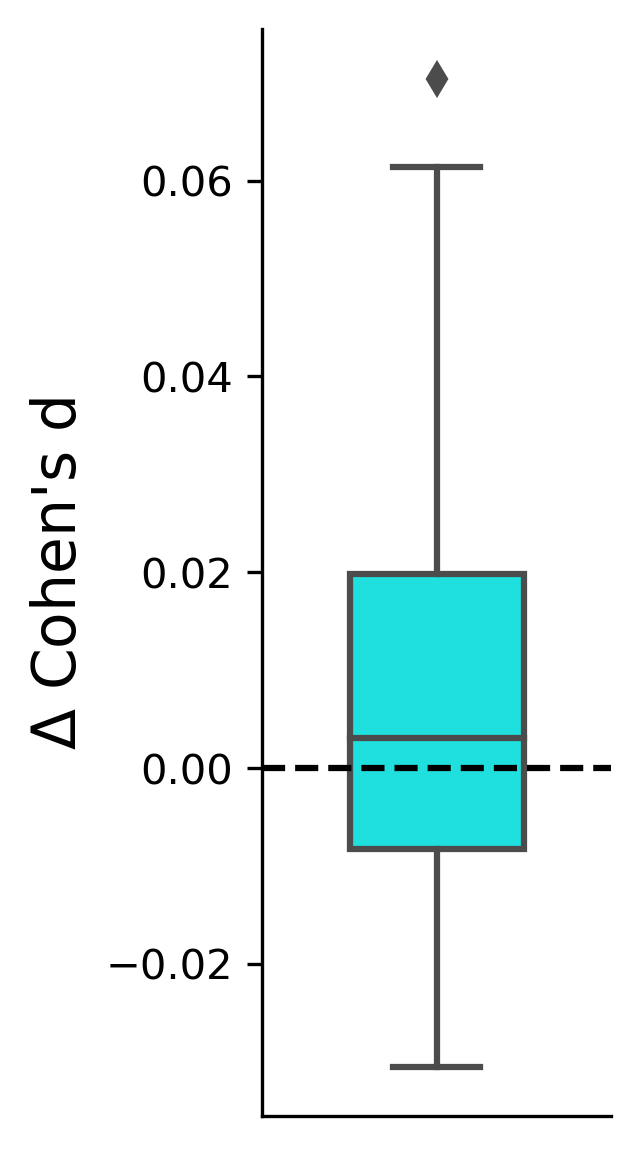

In [14]:
fig, ax = plt.subplots(figsize=(1.5, 4.8))

sns.boxplot(
    y=comp_df_agp_new["es_diff"],
    color="cyan",
    width=0.5,
    ax=ax
)
ax.set_ylabel("$\Delta$ Cohen's d")
ax.tick_params("x", width=0)
ax.axhline(0, ls="--", color="black")

plt.savefig("../figures/redbiom_vs_published_boxplot.pdf")
plt.show()

In [15]:
es_df = pd.read_table("../results/beta_effect_size_by_cat.tsv", sep="\t", index_col=0).dropna()
es_df = es_df[es_df["column"].isin(common_cols)]
print(es_df.shape)
es_df.head(10)

(69, 3)


,effect_size,metric,column
1,0.275675,cohens_d,fungal_overgrowth
3,0.197043,cohens_d,autoimmune
4,0.190181,cohens_d,clinical_condition
5,0.162312,cohens_d,other_supplement_frequency
7,0.132565,cohens_d,multivitamin
8,0.127983,cohens_d,lactose
9,0.111283,cohens_d,nail_biter
12,0.091567,cohens_d,ibs
20,0.037864,cohens_d,cat
21,0.033537,cohens_d,acne_medication_otc


In [16]:
es_df["metric"].value_counts()

cohens_f    54
cohens_d    15
Name: metric, dtype: int64

In [17]:
pa_df = pd.read_table("../results/power_analysis.tsv", sep="\t")
pa_df = pa_df[pa_df["column"].isin(common_cols)]
print(pa_df.shape)
pa_df.head()

(8094, 7)


,alpha,total_observations,power,effect_size,difference,metric,column
114,0.01,20,0.010515,0.094036,NaN,cohens_f,collection_month
115,0.05,20,0.052173,0.094036,NaN,cohens_f,collection_month
116,0.10,20,0.103838,0.094036,NaN,cohens_f,collection_month
117,0.01,60,0.013483,0.094036,NaN,cohens_f,collection_month
118,0.05,60,0.062480,0.094036,NaN,cohens_f,collection_month


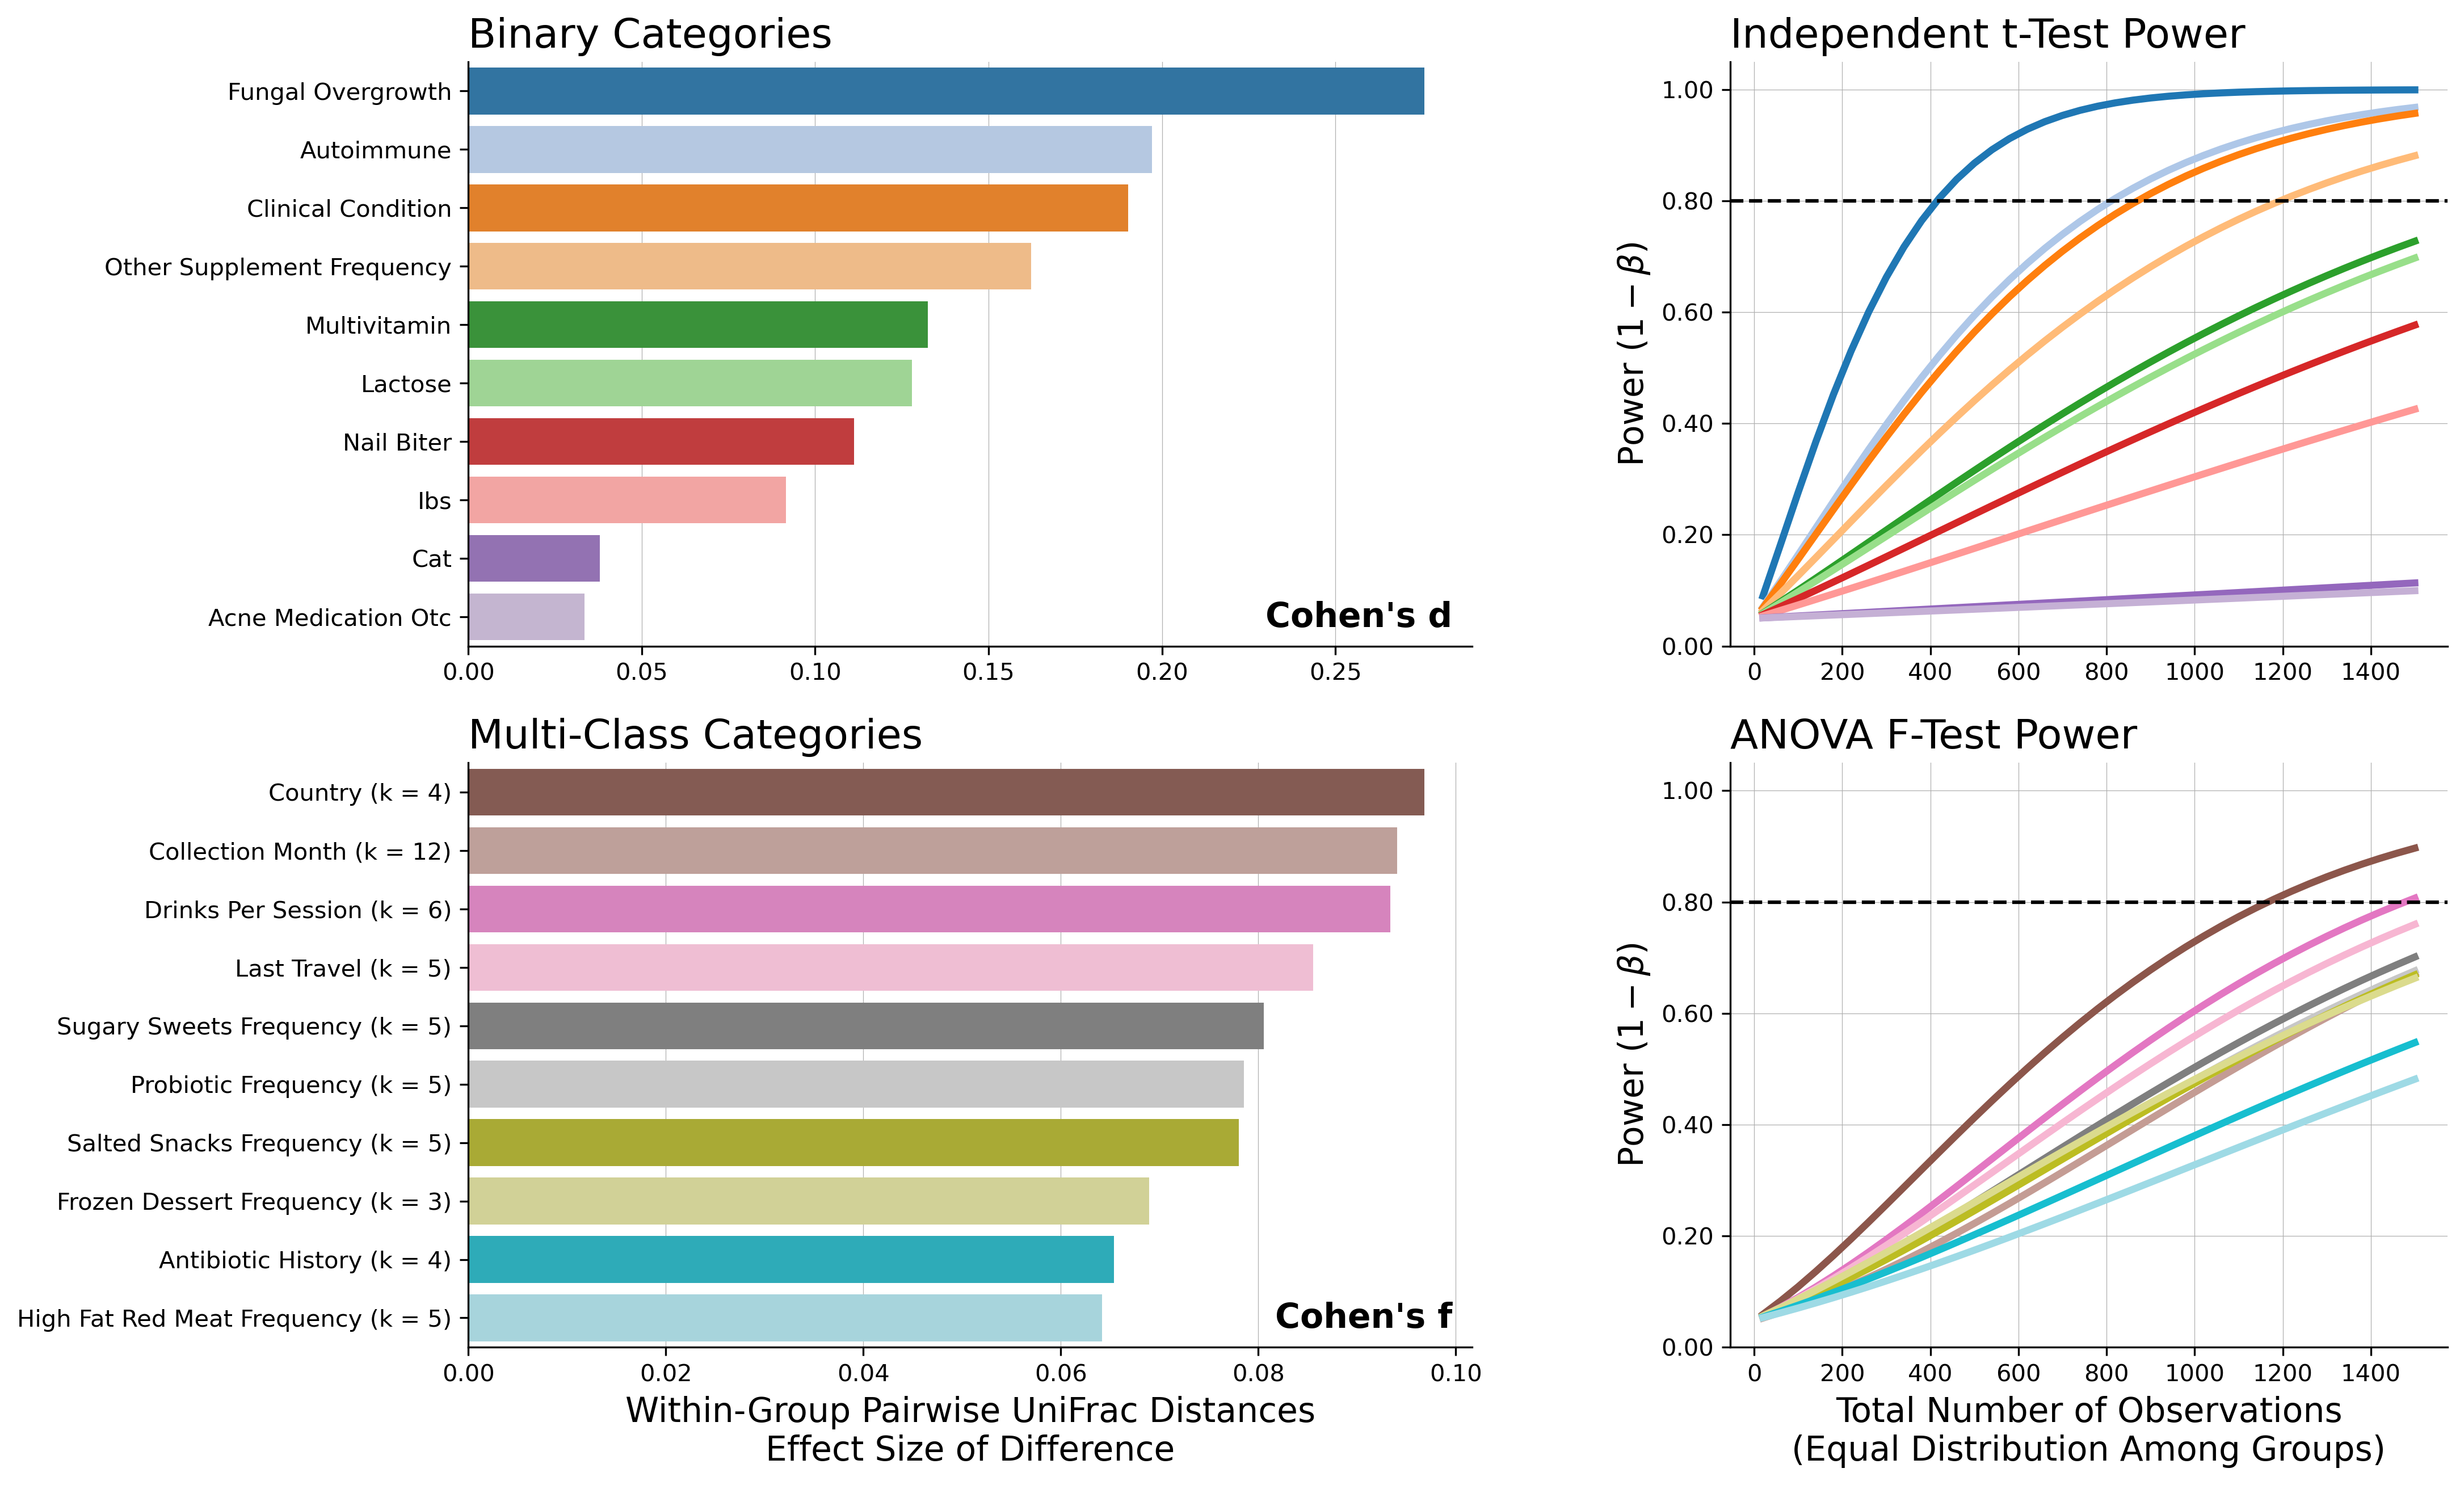

In [18]:
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(nrows=2, ncols=2, width_ratios=[1.4, 1], hspace=0.2, wspace=0.3)
bar_ax_d, pwr_ax_d = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])
bar_ax_f, pwr_ax_f = fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])

n = 10
alpha = 0.05

_es_df_d = es_df.query("metric == 'cohens_d'").head(n)
order_d = _es_df_d["column"]

_es_df_f = es_df.query("metric == 'cohens_f'").head(n)
order_f = _es_df_f["column"]

_pa_df_d = pa_df.query("metric == 'cohens_d' & alpha == @alpha")
_pa_df_d = _pa_df_d[_pa_df_d["column"].isin(order_d)]

_pa_df_f = pa_df.query("metric == 'cohens_f' & alpha == @alpha")
_pa_df_f = _pa_df_f[_pa_df_f["column"].isin(order_f)]

top_cols = order_d.tolist() + order_f.tolist()
cmap = dict(zip(top_cols, sns.color_palette("tab20", n*2)))

bar_args = {"y": "column", "x": "effect_size", "palette": cmap}
text_args = {"x": 0.98, "y": 0.02, "ha": "right", "va": "bottom", "weight": "bold",
             "fontsize": "x-large"}

sns.barplot(**bar_args, data=_es_df_d, ax=bar_ax_d)
bar_ax_d.set_xlabel("")
bar_ax_d.text(**text_args, s="Cohen's d", transform=bar_ax_d.transAxes)

sns.barplot(**bar_args, data=_es_df_f, ax=bar_ax_f)
bar_ax_f.text(**text_args, s="Cohen's f", transform=bar_ax_f.transAxes)
bar_ax_f.set_xlabel("Within-Group Pairwise UniFrac Distances\nEffect Size of Difference")

for ax in [bar_ax_d, bar_ax_f]:
    new_labels = []
    for ytick_label in ax.get_yticklabels():
        text = ytick_label.get_text()
        k = len(df_new[text].dropna().unique())
        text = text.replace("_", " ").title()
        if k > 2:
            text += f" (k = {k})"
        new_labels.append(text)
    ax.set_yticklabels(new_labels)
    ax.set_ylabel("")

## Power
line_args = {"y": "power", "x": "total_observations", "palette": cmap, "hue": "column",
             "lw": 3, "legend": False}
text_args = {"x": 0.98, "y": 0.02, "ha": "right", "va": "bottom", "weight": "bold",
             "fontsize": "x-large"}

sns.lineplot(**line_args, data=_pa_df_d, ax=pwr_ax_d, hue_order=order_d)
pwr_ax_d.set_xlabel("")

sns.lineplot(**line_args, data=_pa_df_f, ax=pwr_ax_f, hue_order=order_f)
pwr_ax_f.set_xlabel("Total Number of Observations\n(Equal Distribution Among Groups)")

for ax in [pwr_ax_d, pwr_ax_f]:
    ax.set_ylabel(r"Power $(1 - \beta)$")
    ax.grid(axis="both")
    ax.set_axisbelow(True)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax.axhline(0.8, color="black", ls="--")
    ax.set_ylim([0, 1.05])
    
for ax in [bar_ax_d, bar_ax_f]:
    ax.grid(axis="x")
    
for ax in [bar_ax_d, bar_ax_f, pwr_ax_d, pwr_ax_f]:
    ax.set_axisbelow(True)
    ax.tick_params("both")
    ax.set_xlabel(ax.get_xlabel())
    
bar_ax_d.set_title("Binary Categories")
bar_ax_f.set_title("Multi-Class Categories")

pwr_ax_d.set_title("Independent t-Test Power")
pwr_ax_f.set_title("ANOVA F-Test Power")

plt.savefig("../figures/effect_sizes_and_power.pdf")
plt.show()

In [19]:
dm = DistanceMatrix.read("../results/distance-matrix-u_unifrac.tsv")

In [20]:
top_binary_cat = (
    es_df[es_df["metric"] == "cohens_d"]
    .sort_values(by="effect_size", ascending=False)
    .iloc[0]
)
grp1_name, grp2_name = df_new[top_binary_cat.column].dropna().unique()
col_name = top_binary_cat.column
grp1 = df_new[df_new[col_name] == grp1_name]
grp2 = df_new[df_new[col_name] == grp2_name]

grp1_vals = dm.filter(grp1.index, strict=False).to_series().values
grp2_vals = dm.filter(grp2.index, strict=False).to_series().values

In [21]:
top_multi_class_cat = (
    es_df[es_df["metric"] == "cohens_f"]
    .sort_values(by="effect_size", ascending=False)
    .iloc[0]
)
mc_col_name = top_multi_class_cat.column
mc_grp_dict = dict()

for grp_name in df_new[mc_col_name].dropna().unique():
    print(grp_name)
    _grp_df = df_new[df_new[mc_col_name] == grp_name]
    _grp_values = dm.filter(_grp_df.index, strict=False).to_series().values
    
    mc_grp_dict[grp_name] = {
        "values": _grp_values,
        "df": _grp_df,
    }

United Kingdom
USA
Australia
Canada


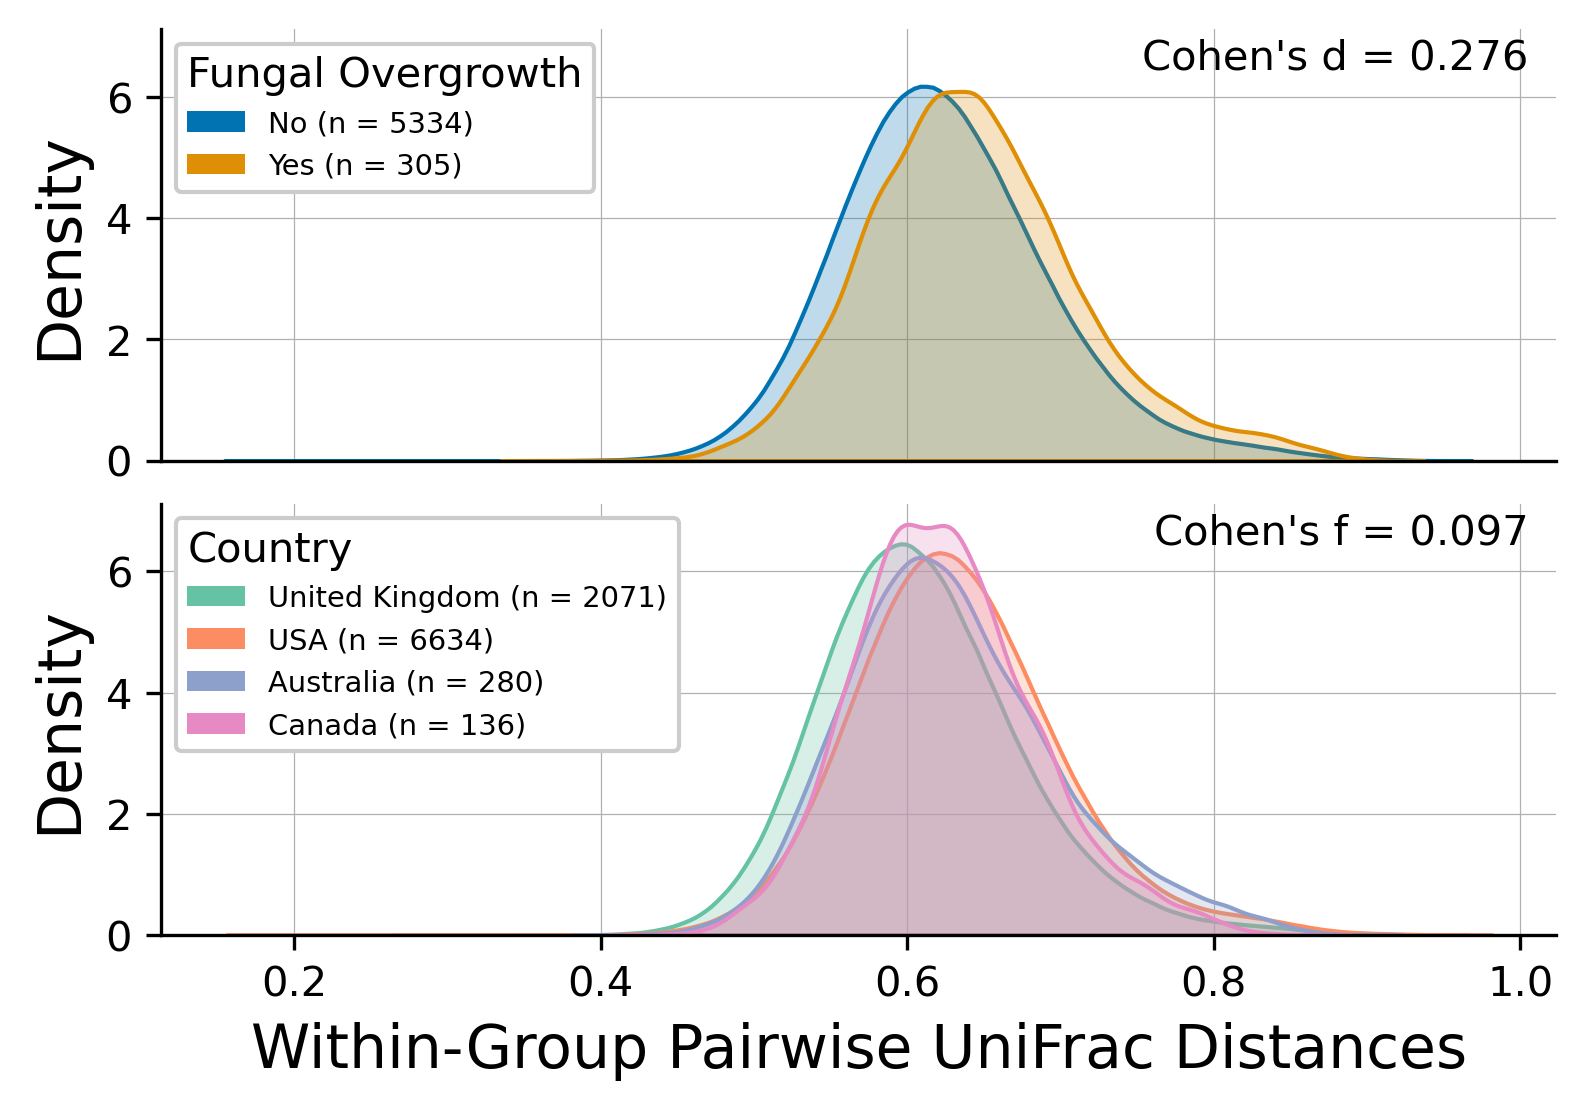

CPU times: user 2min 46s, sys: 5.67 s, total: 2min 52s
Wall time: 2min 52s


In [22]:
%%time

from matplotlib.patches import Patch

fig, axs = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0.1)
ax1 = axs[0]
ax2 = axs[1]

grp1_color, grp2_color = sns.color_palette("colorblind", 2)

colors = [grp1_color, grp2_color]
for grp_values, color in zip([grp1_vals, grp2_vals], colors):
    sns.kdeplot(
        data=grp_values,
        color=color,
        fill=True,
        ax=ax1
    )

ax1.set_ylabel("Density")
ax1.tick_params("x", width=0)

grp1_patch = Patch(facecolor=grp1_color, label=f"{grp1_name} (n = {grp1.shape[0]})")
grp2_patch = Patch(facecolor=grp2_color, label=f"{grp2_name} (n = {grp2.shape[0]})")

leg = ax1.legend(
    handles=[grp1_patch, grp2_patch],
    title=col_name.replace("_", " ").title(),
    loc="upper left",
    framealpha=1
)
leg._legend_box.align = "left"

es = es_df[es_df["column"] == col_name]["effect_size"].item()
ax1.text(
    x=0.98,
    y=0.98,
    s=f"Cohen's d = {es:.3f}",
    transform=ax1.transAxes,
    ha="right",
    va="top",
)

mc_color_dict = dict(zip(mc_grp_dict.keys(), sns.color_palette("Set2", len(mc_grp_dict))))

mc_patches = []
for grp_name, grp_dict in mc_grp_dict.items():
    sns.kdeplot(
        grp_dict["values"],
        color=mc_color_dict[grp_name],
        fill=True,
        ax=ax2
    )
    _n = grp_dict["df"].shape[0]
    _patch = Patch(
        facecolor=mc_color_dict[grp_name],
        label=f"{grp_name} (n = {_n})"
    )
    mc_patches.append(_patch)
    
ax2.set_ylabel("Density")
ax2.set_xlabel("Within-Group Pairwise UniFrac Distances")

leg = ax2.legend(
    handles=mc_patches,
    title=mc_col_name.replace("_", " ").title(),
    loc="upper left",
    framealpha=1
)
leg._legend_box.align = "left"

es = es_df[es_df["column"] == mc_col_name]["effect_size"].item()
ax2.text(
    x=0.98,
    y=0.98,
    s=f"Cohen's f = {es:.3f}",
    transform=ax2.transAxes,
    ha="right",
    va="top",
)

y_max = max([ax1.get_ylim()[1], ax2.get_ylim()[1]])

for ax in axs:
    ax.set_ylim([0, y_max])
    ax.grid()
    ax.set_axisbelow(True)

plt.savefig("../figures/top_cats_distances_combined.pdf")
plt.show()